In [ ]:
"""Perform simple test with LAMOST data"""

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import numpy as np
from astropy.io import fits
import gspice

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Import relevant data

In [3]:
spec = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testDvec.fits")[0].data
cov_doug = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testcov.fits")[0].data
refrms_doug = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testrefrms.fits")[0].data
#wavelength grid for LAMOST data
wvGrid = 3750.0 * 10**(1e-4 * np.arange(3801)) 

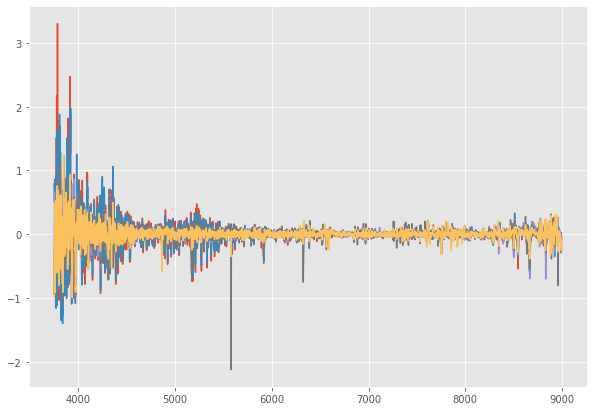

In [4]:
plt.figure(figsize = (10, 7))
for i in range(5):
    plt.plot(wvGrid, spec[i])

## Test `specUtils`

### `standard_scale`

In [5]:
ivar = np.random.randint(0, 2, size = spec.shape)

In [14]:
%time scaled = gspice.standard_scale(spec[:10000], ivar[:10000])

CPU times: user 6.38 s, sys: 2.08 s, total: 8.46 s
Wall time: 10.5 s


~ 56 ms

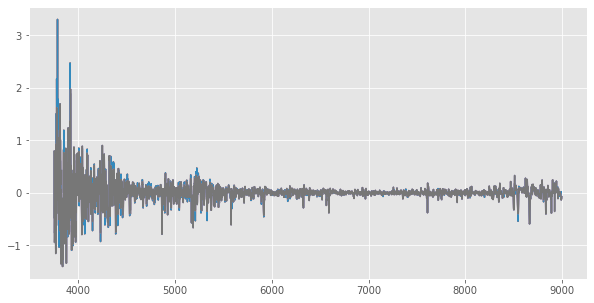

In [15]:
plt.figure(figsize = (10, 5))
for i in range(2):
    plt.plot(wvGrid, spec[i])
    plt.plot(wvGrid, scaled[i])

### `covar`

In [16]:
%time cov, refmean = gspice.covar(spec.astype(np.float64))

min = -8.489075195542582e-14, max = 7.613320490374699e-14, std = 9.592109617097011e-15
CPU times: user 1min 42s, sys: 14 s, total: 1min 56s
Wall time: 1min 6s


In [17]:
#check condition number
np.linalg.cond(cov)

2115867.7203137423

Plot correlation matrix

<AxesSubplot:>

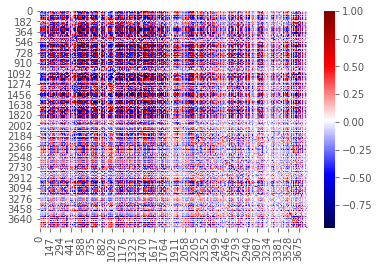

In [18]:
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
sns.heatmap(corr, cmap = 'seismic')

### `get_chimask`

In [21]:
%time chimask = gspice.get_chimask(flux = spec[:100].astype(np.float64), ivar=ivar[:100], mask = (ivar[:100] == 0), nsigma = 8)

min = -1.0880185641326534e-16, max = 1.4210854715202004e-16, std = 1.367254016245195e-17


LinAlgError: 101-th leading minor of the array is not positive definite

# `Everest` dataset

In [20]:
everest = fits.open("/global/cfs/cdirs/desi/users/dfink/stars-everest-r.fits")
everest[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.12           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                47139 /Number of bytes per row                         
NAXIS2  =               198894 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                  117 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [64]:
spec = everest[1].data['SPEC'].astype(np.float64) #originally float32
ivar = everest[1].data['IVAR'].astype(np.float64)
mask = everest[1].data['MASK']
wave = everest[1].data['WAVE'].astype(np.float64)

In [24]:
#nspec X npix
spec.shape

(198894, 2326)

Visualize spectra

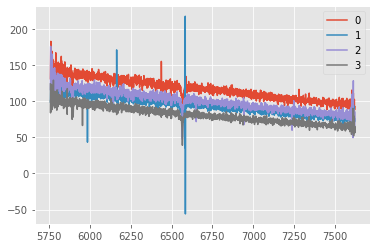

In [27]:
for i in range(4):
    plt.plot(wave[i], spec[i], label = i)
    
plt.legend(loc = 'best')

### `matrixUtils.cholesky_inv`

In [73]:
%time gspice.cholesky_inv(cov);

CPU times: user 814 ms, sys: 137 ms, total: 951 ms
Wall time: 530 ms


array([[ 3.16173887e-05,  1.03504950e+02, -2.07397501e+01, ...,
         7.13281235e+00,  5.12256529e+00,  4.57326663e+00],
       [ 1.03504950e+02,  5.31181667e-07,  2.59353341e+02, ...,
         4.11090677e+01,  8.22435857e-03,  1.93885750e+01],
       [-2.07397501e+01,  2.59353341e+02,  2.86780426e-08, ...,
        -1.62280356e+00, -1.83370276e+00, -8.01245118e-01],
       ...,
       [ 7.13281235e+00,  4.11090677e+01, -1.62280356e+00, ...,
         1.89653090e-04,  5.77234282e+00,  6.14314803e+00],
       [ 5.12256529e+00,  8.22435857e-03, -1.83370276e+00, ...,
         5.77234282e+00,  2.40280989e-04,  2.05122253e+01],
       [ 4.57326663e+00,  1.93885750e+01, -8.01245118e-01, ...,
         6.14314803e+00,  2.05122253e+01,  2.26513854e-04]])

### `matrixUtils.submatrix_inv`

In [74]:
M = np.random.random((3, 3))
M

array([[0.84539759, 0.36429484, 0.13025326],
       [0.24567662, 0.86756222, 0.68133414],
       [0.58103634, 0.49632124, 0.89282151]])

In [75]:
Minv = gspice.cholesky_inv(M)

In [76]:
imask = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
imask

array([[1, 0, 1],
       [0, 0, 0],
       [1, 0, 1]])

In [114]:
%time gspice.submatrix_inv(M, Minv, imask)

CPU times: user 429 µs, sys: 111 µs, total: 540 µs
Wall time: 448 µs


array([[ 1.07132805, -0.06714715],
       [-0.06714715,  2.70830662]])

### `matrixUtils.submatrix_inv_mult`

In [121]:
Y = np.random.random(3).reshape(-1, 1)
Y

array([[0.361427  ],
       [0.24686044],
       [0.6034804 ]])

In [122]:
MinvY = Minv @ Y

In [124]:
%time gspice.submatrix_inv_mult(M, Minv, imask, Y, MinvY)

CPU times: user 397 µs, sys: 103 µs, total: 500 µs
Wall time: 411 µs


array([[0.34668489],
       [0.        ],
       [1.61014117]])

### `specUtils.covar`

In [30]:
%time cov, refmean = gspice.covar(spec = spec.astype(np.float64)) #by default everest is float32

min = -2.7777122649647156e-08, max = 1.185035572931582e-07, std = 2.8051432285089112e-09
CPU times: user 35.9 s, sys: 7.83 s, total: 43.7 s
Wall time: 27.5 s


<AxesSubplot:>

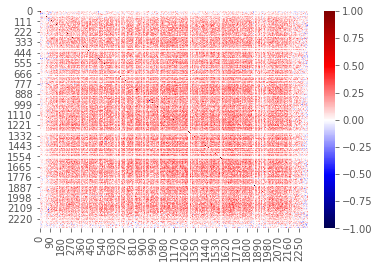

In [31]:
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
sns.heatmap(corr, cmap = 'seismic')

### `covar_iter_mask`

In [80]:
%time cov_iter, finalmask = gspice.covar_iter_mask(flux = spec, ivar = ivar, mask = mask)

KeyboardInterrupt: 